<a href="https://colab.research.google.com/github/Cristian-Cortez/CSE337-labs/blob/main/lab10_half_cheetah_dynamics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# HalfCheetah: Learn a Dynamics Model from Random Rollouts (Then Validate It)

**Goal:** In this notebook you'll (1) collect random experience tuples \((s_t, a_t, r_t, s_{t+1})\) from `HalfCheetah-v4`, (2) train a neural network to predict **state deltas** \(\Delta s = s_{t+1}-s_t\), and (3) **validate** the model with one-step and multi-step (open-loop) rollouts.

This mirrors the first phase of model-based control (e.g., MPPI): learn a model offline, then use it for planning.



## 0. Requirements

- Python 3.9+
- PyTorch `>= 1.10`
- Gymnasium `>= 0.29`
- MuJoCo with `HalfCheetah-v4` (install `mujoco` and `gymnasium[mujoco]`)

```bash
pip install "gymnasium[mujoco]" mujoco torch matplotlib
```

**Try and understand what RunningNormalizer does.**


In [5]:
!pip install "gymnasium[mujoco]" mujoco torch matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.5/243.5 kB 14.1 MB/s eta 0:00:00


In [17]:

import os, math, random, time
from dataclasses import dataclass
from typing import Tuple
import numpy as np
import torch as th
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import gymnasium as gym

def to_t(x):
    return th.as_tensor(x, dtype=th.float32)

def fanin_init(m):
    if isinstance(m, nn.Linear):
        bound = 1.0 / math.sqrt(m.weight.size(1))
        nn.init.uniform_(m.weight, -bound, +bound)
        nn.init.zeros_(m.bias)

class RunningNormalizer:
    """Feature-wise running mean/std (Welford)."""
    def __init__(self, dim, eps=1e-8):
        self.dim = dim
        self.count = 0
        self.mean = np.zeros(dim, dtype=np.float64)
        self.M2   = np.zeros(dim, dtype=np.float64)
        self.eps  = eps

    def update(self, x: np.ndarray):
        x = np.asarray(x)
        if x.ndim == 1: x = x[None, :]
        for v in x:
            self.count += 1
            d = v - self.mean
            self.mean += d / self.count
            d2 = v - self.mean
            self.M2 += d * d2

    @property
    def var(self):
        if self.count < 2: return np.ones(self.dim, dtype=np.float64)
        return self.M2 / (self.count - 1 + 1e-12)

    @property
    def std(self):
        return np.sqrt(self.var + self.eps)

    def normalize(self, x): return (x - self.mean) / self.std
    def denormalize(self, x): return x * self.std + self.mean

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); th.manual_seed(seed)



## Initializing Environment and Figure Out Observation Structure

`HalfCheetah-v4` exposes observations as `[qpos[1:], qvel[:]]`. The forward velocity is `qvel[0]`, which sits at index `len(qpos[1:])` inside the observation vector. We'll extract that index for later validation/plots. :::: This is important for planning, if we want to know what each state represents


In [31]:

set_seed(42)
env = gym.make("HalfCheetah-v4")
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]
act_low = env.action_space.low
act_high = env.action_space.high

# Find start index of qvel inside obs = [qpos[1:], qvel[:]]
nq = env.unwrapped.model.nq
qvel_start = int(nq - 1)
print("obs_dim:", obs_dim, "act_dim:", act_dim, "qvel_start:", qvel_start)


obs_dim: 17 act_dim: 6 qvel_start: 8


/usr/local/lib/python3.12/dist-packages/gymnasium/envs/registration.py:512: DeprecationWarning: WARN: The environment HalfCheetah-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(


## 🧩 Task 1: Prepare the Replay Buffer
**Goal:** Store transitions \((s_t, a_t, s_{t+1})\) and return training pairs \((x, y) = (s_t, a_t, s_{t+1} - s_t)\).

**Instructions:**
- Implement `add()` to record transitions.
- Add a `sample()` method to randomly sample batch of certain size.



In [33]:
# Create the class and create a class object
class Replay:
    def __init__(self, obs_dim, act_dim, capacity=300000):
        self.obs = np.zeros((capacity, obs_dim), dtype=np.float32)
        self.act = np.zeros((capacity, act_dim), dtype=np.float32)
        self.nxt = np.zeros((capacity, obs_dim), dtype=np.float32)
        self.rew = np.zeros((capacity, 1), dtype=np.float32)
        self.term = np.zeros((capacity, 1), dtype=np.float32)
        self.ptr = 0; self.size = 0; self.cap = capacity

    def add(self, s, a, r, sp, term):
        self.obs[self.ptr] = s
        self.act[self.ptr] = a
        self.rew[self.ptr] = r
        self.nxt[self.ptr] = sp
        self.term[self.ptr] = term

        # Move pointer cyclically
        self.ptr = (self.ptr + 1) % self.cap
        self.size = min(self.size + 1, self.cap)

    def sample(self, batch):
        idx = np.random.randint(0, self.size, size=batch)

        s = self.obs[idx]
        a = self.act[idx]
        sp = self.nxt[idx]

        # Model-based target: predict next-state delta
        x = np.concatenate([s, a], axis=-1)   # Input = [s_t, a_t]
        y = sp - s                            # Output = Δs = s_{t+1} - s_t

        return to_t(x), to_t(y)

replay = Replay(obs_dim, act_dim)


0



## Task 2. Collect Random Rollouts

- Gather random actions for a number of steps to create our training dataset. Collect data for 100000 steps.
- Call the function and fill the replay buffer


In [35]:

def collect_random(env, replay, steps=10000, seed=42):
    set_seed(seed)
    obs, _ = env.reset(seed=seed)

    for step in range(steps):
        # Sample random action from environment's action space
        act = env.action_space.sample()
        nxt, rew, term, trunc, _ = env.step(act)

        # Add transition to replay buffer
        replay.add(obs, act, rew, nxt, term or trunc)

        # Move to next state; reset if episode ends
        if term or trunc:
           obs, _ = env.reset(seed=seed)
        else:
            obs = nxt
collect_random(env, replay, steps = 100000)


## Task 3. Update normalizers from the collected random data in the replay buffer

We normalize inputs (`[s,a]`) and targets (`Δs = s' - s`) for stable training.


In [36]:

obs_norm = RunningNormalizer(obs_dim)
inp_norm = RunningNormalizer(obs_dim + act_dim)
targ_norm = RunningNormalizer(obs_dim)

# write the function to update the normalizers from the data collected in the buffer
def update_normalizers_from_buffer(replay):
    global obs_norm, inp_norm, targ_norm  # use the existing normalizers

    # Extract all stored transitions
    s = replay.obs[:replay.size]
    a = replay.act[:replay.size]
    sp = replay.nxt[:replay.size]

    # Compute model-based target: delta state
    delta = sp - s
    inp = np.concatenate([s, a], axis=-1)

    # Update each normalizer
    obs_norm.update(s)
    inp_norm.update(inp)
    targ_norm.update(delta)

update_normalizers_from_buffer(replay)
print("Normalizers ready.")


Normalizers ready.



## Defining the Neural Dynamics Model

We predict **normalized** `Δs` from **normalized** `[s, a]`.
NN parameters:

- initialize a deterministic NN with a ExponentialLR sceduler( that decays the learning rate with epoch)
- width = 200, depth = 3, lr = 1e-3, weight_decay - 1e-5, gamma for scheduler = 0.8
- These are a starting point but not the best parameters.


In [37]:

class DetMLP(nn.Module):
    """Predicts Δstate deterministically."""
    def __init__(self, in_dim, out_dim, width=200, depth=3):
        super().__init__()
        layers = []
        last = in_dim
        for _ in range(depth):
            layers += [nn.Linear(last, width), nn.ReLU()]
            last = width
        layers += [nn.Linear(last, out_dim)]
        self.net = nn.Sequential(*layers)
        self.apply(fanin_init)

    def forward(self, x):
        return self.net(x)

in_dim = obs_dim + act_dim
out_dim = obs_dim
model = DetMLP(in_dim, out_dim, width=200, depth=3)
opt = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ExponentialLR(opt, gamma=0.8)



## Task 4. Train the Model

We minimize MSE between predicted normalized `Δs` and target normalized `Δs`.

- Train in batches, keep the batch size 256
- Use a learning rate scheduler that decays the learning rate as training progresses. You may use the pytorch utility. See how the learning rate decays with each epoch.
- Train for 30 epochs and plot the training curve. Loss vs epoch.
- Find the best parameters(defined in the previous block)



Epoch [1/10]  Loss: 0.095266  LR: 8.000000e-04
Epoch [2/10]  Loss: 0.050662  LR: 6.400000e-04
Epoch [3/10]  Loss: 0.039197  LR: 5.120000e-04
Epoch [4/10]  Loss: 0.032980  LR: 4.096000e-04
Epoch [5/10]  Loss: 0.028829  LR: 3.276800e-04
Epoch [6/10]  Loss: 0.026310  LR: 2.621440e-04
Epoch [7/10]  Loss: 0.024280  LR: 2.097152e-04
Epoch [8/10]  Loss: 0.022665  LR: 1.677722e-04
Epoch [9/10]  Loss: 0.021518  LR: 1.342177e-04
Epoch [10/10]  Loss: 0.020950  LR: 1.073742e-04
100000


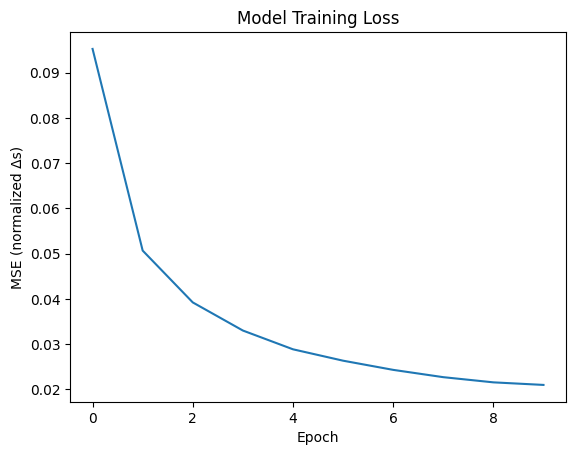

In [39]:

def train_model(model, replay, epochs=30, batch_size=256):
    losses = []
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        epoch_loss = 0.0
        num_batches = max(1, replay.size // batch_size)  # avoid divide-by-zero

        for _ in range(num_batches):
            # Sample random batch indices
            idx = np.random.randint(0, replay.size, size=batch_size)

            s = replay.obs[idx]
            a = replay.act[idx]
            sp = replay.nxt[idx]

            # Compute Δs and form input [s, a]
            delta = sp - s
            x = np.concatenate([s, a], axis=-1)

            # Normalize input and target
            x = to_t(inp_norm.normalize(x))
            y = to_t(targ_norm.normalize(delta))

            # Forward pass
            pred = model(x)
            loss = loss_fn(pred, y)

            # Backward pass
            opt.zero_grad()
            loss.backward()
            opt.step()

            epoch_loss += loss.item()

        # Average epoch loss
        epoch_loss /= num_batches
        losses.append(epoch_loss)

        # Step scheduler
        scheduler.step()
        current_lr = scheduler.get_last_lr()[0]
        print(f"Epoch [{epoch+1}/{epochs}]  Loss: {epoch_loss:.6f}  LR: {current_lr:.6e}")

    return losses

losses = train_model(model, replay, epochs=10, batch_size=64)
print(replay.size)
plt.figure()
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("MSE (normalized Δs)")
plt.title("Model Training Loss")
plt.show()


## Task 5. Validate your model: One-Step and Multi-Step Prediction Error

- Evaluate your trained model on a held-out set of random transitions.
Generate a batch of unseen samples, predict the next-state delta, and compute the one-step MSE.

- Repeat with open-loop rollouts of length k.
Drive both the real environment and the model with the same action sequence, then report how prediction error grows across steps.

One-step MSE (normalized Δs): 0.019391
One-step MSE (real Δs): 0.417144


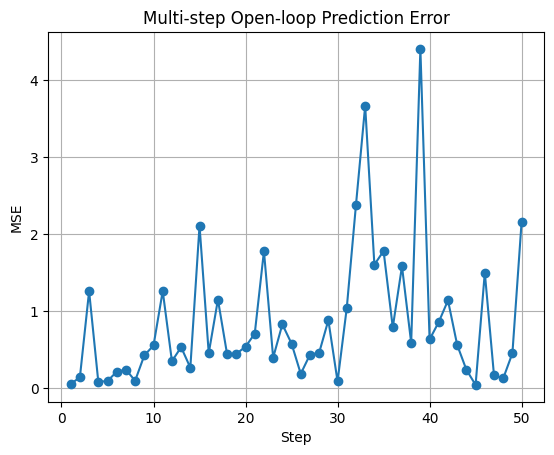

In [40]:

# your code here
def one_step_mse(model, replay, batch_size=1024):
    # Sample a batch of unseen transitions
    x_batch, y_batch = replay.sample(batch_size)

    # Normalize using normalizers
    x_batch_norm = to_t(inp_norm.normalize(x_batch.numpy()))
    y_batch_norm = to_t(targ_norm.normalize(y_batch.numpy()))

    # Predict
    with th.no_grad():
        pred = model(x_batch_norm)

    # Compute MSE in normalized Δs space
    mse_norm = nn.MSELoss()(pred, y_batch_norm).item()

    # Also compute MSE in original Δs space
    pred_denorm = targ_norm.denormalize(pred.numpy())
    mse_real = np.mean((pred_denorm - y_batch.numpy())**2)

    print(f"One-step MSE (normalized Δs): {mse_norm:.6f}")
    print(f"One-step MSE (real Δs): {mse_real:.6f}")

    return mse_norm, mse_real

def multi_step_mse(model, env, init_obs, action_seq):
    """
    Rollout model and environment using the same actions.
    Compare model predictions vs environment states.

    init_obs: starting observation
    action_seq: sequence of actions to apply
    """
    obs_real = init_obs.copy()
    obs_model = init_obs.copy()
    errors = []

    for a in action_seq:
        # Environment step
        next_real, _, done, trunc, _ = env.step(a)

        # Model step (predict Δs)
        x = np.concatenate([obs_model, a])[None, :]  # batch dimension
        x_norm = to_t(inp_norm.normalize(x))
        with th.no_grad():
            delta_pred = model(x_norm).numpy()
        delta_pred = targ_norm.denormalize(delta_pred)[0]

        next_model = obs_model + delta_pred

        # Compute MSE for this step
        mse_step = np.mean((next_real - next_model)**2)
        errors.append(mse_step)

        # Update states
        obs_real = next_real
        obs_model = next_model

        if done or trunc:
            obs_real, _ = env.reset()

    return errors

# 1. One-step error
one_step_mse(model, replay, batch_size=1024)

# 2. Multi-step error (e.g., rollout length k=50)
k = 50
env.reset(seed=123)
obs, _ = env.reset()
action_seq = [env.action_space.sample() for _ in range(k)]
errors = multi_step_mse(model, env, obs, action_seq)

# Plot prediction error over steps
plt.figure()
plt.plot(range(1, k+1), errors, marker='o')
plt.xlabel("Step")
plt.ylabel("MSE")
plt.title("Multi-step Open-loop Prediction Error")
plt.grid(True)
plt.show()



## Task 6. Visualize Rollout Trajectories

**Setup**
Call model.eval() so gradients stay off.
Reset the env with the provided seed; keep a copy of the initial observation.


**Choose actions**
Pre-sample k actions from env.action_space.sample() so the real system and the model rollout see the same sequence.

**Roll forward**
For each action:
Step the real env (env.step(a)), append the new observation.
For the model path:
Build [s_model, a], normalize via inp_norm.normalize, turn into a tensor with to_t.
Run the network, de-normalize with targ_norm.denormalize, add to the last model state, append.
Stop early if the env terminates or truncates.

**Plot**
Plot the real trajectory as one line, model trajectory as another.



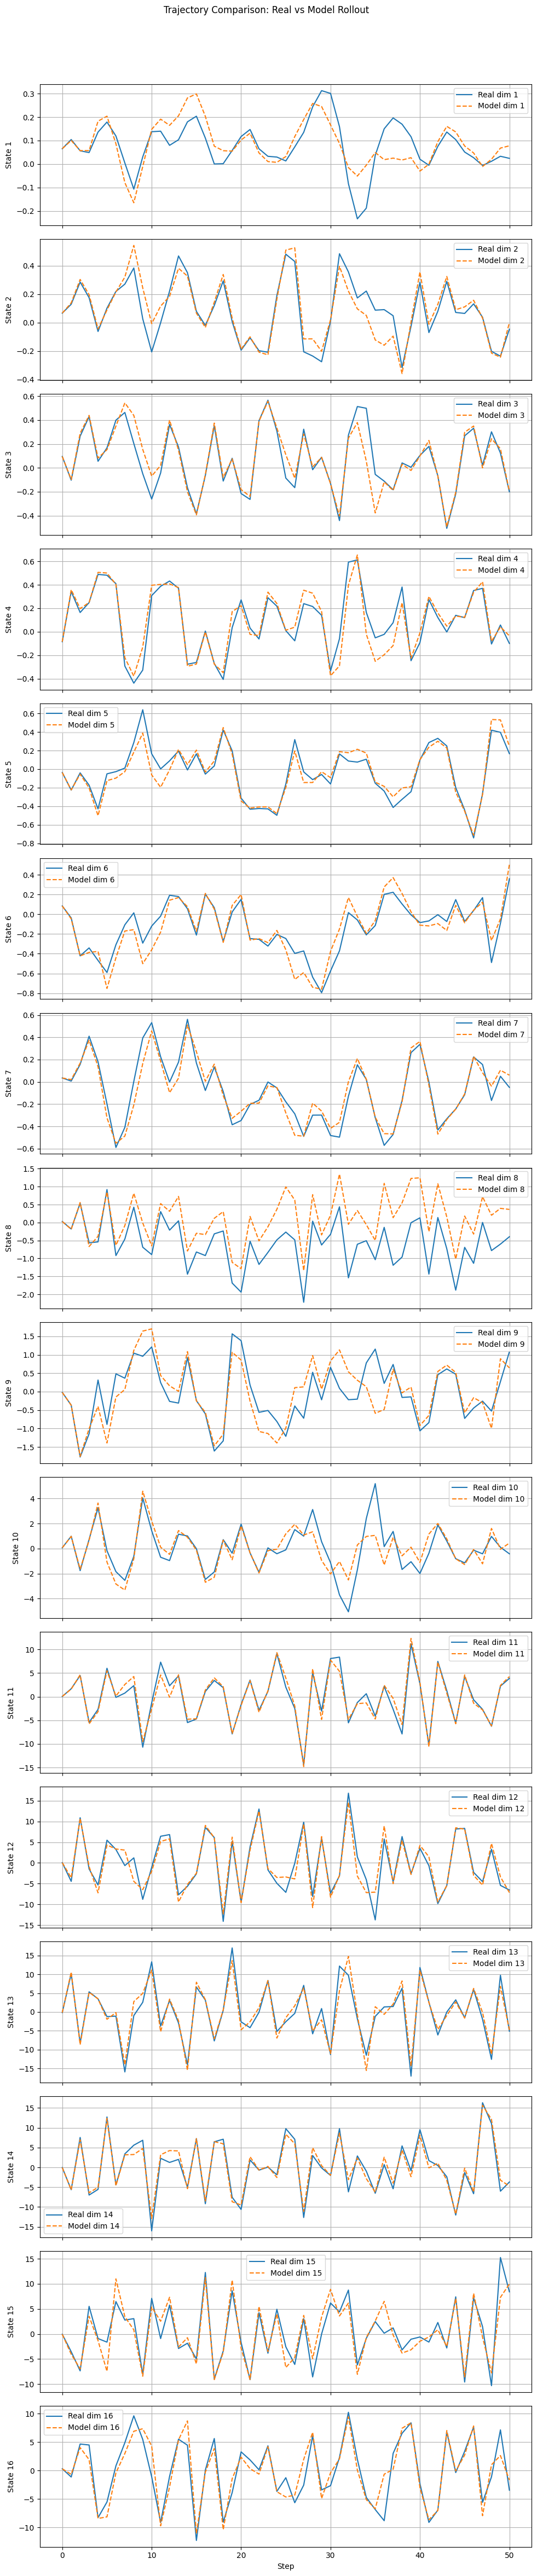

In [42]:

def visualize_rollout(env, model, k=50, dims=(0, 5, 10), seed=2025):
    """
    Compare real environment trajectory vs model rollout.
    Each selected dimension gets its own subplot.

    dims: which state dimensions to plot (tuple or list)
    k: rollout length
    """
    model.eval()  # disable gradients

    # Reset environment and store initial observation
    obs_real, _ = env.reset(seed=seed)
    obs_model = obs_real.copy()

    # Store trajectories
    traj_real = [obs_real.copy()]
    traj_model = [obs_model.copy()]

    # Pre-sample actions
    action_seq = [env.action_space.sample() for _ in range(k)]

    for a in action_seq:
        # Step environment
        next_real, _, done, trunc, _ = env.step(a)
        traj_real.append(next_real.copy())

        # Step model
        x = np.concatenate([obs_model, a])[None, :]  # add batch dimension
        x_norm = to_t(inp_norm.normalize(x))
        with th.no_grad():
            delta_pred = model(x_norm).numpy()
        delta_pred = targ_norm.denormalize(delta_pred)[0]

        obs_model = obs_model + delta_pred
        traj_model.append(obs_model.copy())

        if done or trunc:
            break

    traj_real = np.array(traj_real)
    traj_model = np.array(traj_model)

    # Create subplots
    n_dims = len(dims)
    fig, axes = plt.subplots(n_dims, 1, figsize=(10, 3*n_dims), sharex=True)

    if n_dims == 1:
        axes = [axes]  # make it iterable

    for i, d in enumerate(dims):
        axes[i].plot(traj_real[:, d], label=f"Real dim {d}", linestyle='-')
        axes[i].plot(traj_model[:, d], label=f"Model dim {d}", linestyle='--')
        axes[i].set_ylabel(f"State {d}")
        axes[i].legend()
        axes[i].grid(True)

    axes[-1].set_xlabel("Step")
    plt.suptitle("Trajectory Comparison: Real vs Model Rollout")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()



# Uncomment to visualize
dims = list(range(1, 17))
visualize_rollout(env, model, k=50, dims=dims)#(qvel_start, qvel_start+1, qvel_start+2))



## 9. Answer the questions :

1. How good is your model?


*   As seen in the visualizations of the rollouts, the model is very close to the to the real dim. There are some discreptancies, but overall it did a good job at simulation.


2. Is this training enough for planning, or do we need continual training?


*   I believe we need continual training. I think we have enough data points for the short term, but for longer horizons, the accuracy of the data will start to degrade, so continual learning will be needed to ensure that the model stays accurate.


3. How is this system different from the mountain car problem? Why can't we learn this in one episode?

*   This system has a much larger state AND action space than the mountain car problem, which was only 2D and could move left or right. This in inself causes a lot more variablility for the cheetah than for the mountain car, which would take a lot more computation than we can perfect in just one episode.

4. Why do we use a runningnormalizer instead of a static normalizer? Think about the nature of the algorithm taught in class.

*   The runningnormalizer allows for continuous updates as the new data arrives. This is important because the nature of the algorithms in class are iterative, so the model must continue learning. The data is not stationary, meaning that the static normalizer would use only the inital data and make no further updates, therfore it would not make sense for an iterative proccess like PETS or MPPI.